In [ ]:
# Zachary Katz
# zachary_katz@mines.edu
# 27 May 2025

"""
Example harmonic analysis 
"""

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from utide import solve
import pandas as pd

import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'Tides' from '/home/zkatz/Research/harmonic-analysis/src/Tides/__init__.py'>

In [2]:
# Satellite repeat times [hr]
HR_IN_DAY = 24
SEC_IN_HR = 3600
T_icesat2 = 90.8193 * HR_IN_DAY  # 90.8193 days in hrs (From ATL03 POD ATBD)
T_swot = 20.86455 * HR_IN_DAY  # 21 days in hrs
T_cryosat_subcycle = 28.941 * HR_IN_DAY  # 28 days in hrs
T_jason = 9.9156 * HR_IN_DAY  # 9 days in hrs

# Tidal constituents [hr]
M2 = 12.4206012
S2 = 12
N2 = 12.65834751
K2 = 11.96723606

K1 = 23.9344721
O1 = 25.81933871
P1 = 24.06588766
Q1 = 26.868350

constituents = {
    "M2": M2,
    "S2": S2,
    "N2": N2,
    "K2": K2,
    "K1": K1,
    "O1": O1,
    "P1": P1,
    "Q1": Q1,
}

In [3]:
def tide_model(t, periods, parameters):
    """
    Generate the tide from synthetic data.

    Parameters
    ----------
    t : List
        List of sampling times in hours
    periods : dict
        Dictionary of tidal constituent periods in hours
    parameters : list
        List in form [A1, A2, ... , phi_1, phi_2, ...]
        where A is the amplitude in m and phi is the phase shift in radians

    Returns
    -------
    modeled : list
        Tides at time t as estimated by the model
    """
    assert len(parameters) == 2 * len(
        periods
    ), "Parameters must be twice the number of periods"

    model = np.zeros_like(t, dtype=float)
    n = len(periods)
    for i in range(n):
        A = parameters[i]
        phi = parameters[i + n]
        model += A * np.cos(2 * np.pi * t / periods[i] - phi)
    return model


def residuals(parameters, t, data, periods):
    """
    Residual function for scipy's least_squares
    Scipy does the squaring for us.
    """
    return tide_model(t, periods, parameters) - data

True: 1.000, Fitted: 0.845
True: 2.000, Fitted: 2.008
True: 0.300, Fitted: 0.333
True: 2.000, Fitted: 2.024
True: 1.000, Fitted: 1.111
True: 2.000, Fitted: 2.040
True: 0.000, Fitted: -0.111
True: 1.000, Fitted: 1.030
True: 0.000, Fitted: -0.007
True: 0.000, Fitted: -0.010
True: 0.000, Fitted: 0.138
True: 0.000, Fitted: -0.084
True: 1.571, Fitted: 1.596
True: 0.393, Fitted: 0.369
True: 0.000, Fitted: -1.296
True: 0.785, Fitted: 0.820


Text(0, 0.5, 'Tide [m]')

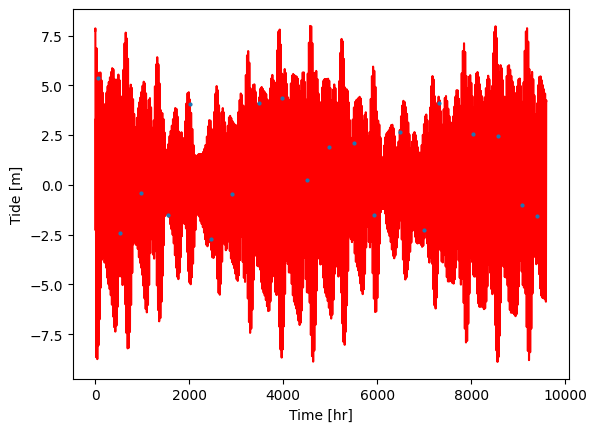

In [4]:
step = T_swot  # hrs
t = np.arange(0, 400 * 24, step)
t = t + np.random.normal(0, 100, len(t))  # Nonuniform sampling
periods = [constituents[c] for c in constituents]
true_values = [1, 2, 0.3, 2, 1, 2, 0, 1, 0, 0, 0, 0, np.pi / 2, np.pi / 8, 0, np.pi / 4]

synthetic_data = tide_model(t, periods, true_values) + np.random.normal(0, 0.2, len(t))

initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, synthetic_data, periods))

# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    print(f"True: {true:.3f}, Fitted: {fitted:.3f}")

fig, ax = plt.subplots()
ax.scatter(t, synthetic_data, s=4)
fit_times = np.arange(0, 400 * 24, 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [5]:
t_as_time = pd.date_range(start="2020-01-02T08:50:00", periods=len(t), freq=f"{step}h")
# Utide analysis
soln = solve(t_as_time, synthetic_data, lat=-84.2986, method="ols", conf_int="MC")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... 

LinAlgError: SVD did not converge

In [6]:
# Try with IceSat-2 crossover at gz05
# User-defined path
data_path = "../data/ATL11/"

# Download ATL11 if necessary
results = earthaccess.search_data(
    short_name="ATL11",
    granule_name="ATL11_134011_0326_006_12.h5",
)
print(results)
earthaccess.download(results, data_path, provider="POCLOUD")
files = list(Path(data_path).glob("*.h5"))

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -153.59526, 'Latitude': -78.98162}, {'Longitude': -153.87878, 'Latitude': -78.9677}, {'Longitude': -153.99141, 'Latitude': -78.98917}, {'Longitude': -155.48991, 'Latitude': -80.24384}, {'Longitude': -160.10742, 'Latitude': -82.8004}, {'Longitude': -164.22914, 'Latitude': -84.16105}, {'Longitude': 178.20076, 'Latitude': -86.664}, {'Longitude': 157.00415, 'Latitude': -87.60905}, {'Longitude': 88.84637, 'Latitude': -87.43669}, {'Longitude': 56.05837, 'Latitude': -84.17317}, {'Longitude': 49.46781, 'Latitude': -81.64929}, {'Longitude': 47.27274, 'Latitude': -80.24236}, {'Longitude': 45.77733, 'Latitude': -78.98982}, {'Longitude': 45.71627, 'Latitude': -78.97243}, {'Longitude': 45.60891, 'Latitude': -78.96835}, {'Longitude': 45.53695, 'Latitude': -78.97633}, {'Longitude': 45.24915, 

QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1709.52it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 17189.77it/s]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 29228.60it/s]


In [7]:
# Make array of ATL11 data
data_arr = []

# Each reference track pair is a group
group = ["/pt1/", "/pt2/", "/pt3/"]

# Loop over files
for file in files[:7]:
    # Loop over pairs
    for i, g in enumerate(group):
        data = {}
        # Load variables into dictionary list
        with h5py.File(file, "r") as fi:
            data["t_ref"] = fi["/ancillary_data/atlas_sdp_gps_epoch"][
                :
            ]  # ICESat-2 reference epoch
            data["filename"] = file
            data["group"] = g

            # Crossing track data
            data["x_q_flag"] = fi[g + "crossing_track_data/atl06_quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["x_lat"] = fi[g + "crossing_track_data/latitude"][
                :
            ]  # Latitude [degrees]
            data["x_lon"] = fi[g + "crossing_track_data/longitude"][
                :
            ]  # Longitude [degrees]
            data["x_h_corr"] = fi[g + "crossing_track_data/h_corr"][
                :
            ]  # Mean corrected height [m]
            data["x_t_dt"] = fi[g + "crossing_track_data/delta_time"][
                :
            ]  # GPS seconds since reference epoch
            data["x_cycle_number"] = fi[g + "crossing_track_data/cycle_number"][
                :
            ]  # Cycle
            data["x_rgt"] = fi[g + "crossing_track_data/rgt"][
                :
            ]  # Reference ground track
            data["x_spot_crossing"] = fi[g + "crossing_track_data/spot_crossing"][
                :
            ]  # Spot  number
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][
                :
            ]  # Reference point

            time_temp = data["t_ref"] + data["x_t_dt"]
            data["x_time"] = Time(
                time_temp, format="gps"
            ).iso  # Convert to readable time

            # Main track data
            data["lat"] = fi[g + "/latitude"][:]  # Latitude [degrees]
            data["lon"] = fi[g + "/longitude"][:]  # Longitude [degrees]
            data["h_corr"] = fi[g + "/h_corr"][:]  # Mean corrected height [m]
            data["t_dt"] = fi[g + "/delta_time"][:]  # GPS seconds since reference epoch
            data["q_flag"] = fi[g + "/quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["cycle_number"] = fi[g + "/cycle_number"][:]  # Cycle
            data["ref_pt"] = fi[g + "/ref_pt"][:]  # Reference point
            time_temp = data["t_ref"] + data["t_dt"]
            data["time"] = Time(time_temp, format="gps").iso  # Convert to readable time

        data_arr.append(data)

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/erfa/core.py:16223: Ru

In [8]:
# Find closest point to gz05 for data_arr[0]
trk_X = data_arr[0]
gz05_lat, gz05_lon = -84.2986, -164.5206
lat_lon = np.column_stack((trk_X["x_lat"], trk_X["x_lon"]))
dists = np.linalg.norm(lat_lon - [gz05_lat, gz05_lon], axis=1)
min_index = np.argmin(dists)
print(lat_lon[min_index], dists[min_index], min_index)
ref_pt = trk_X["x_ref_pt"][min_index]

mskx = (trk_X["x_ref_pt"] == ref_pt) & (trk_X["x_t_dt"] < 2e300)
msk = trk_X["ref_pt"] == ref_pt
print(trk_X["x_rgt"][mskx])
mskd_lat = trk_X["lat"][msk]
mskd_lon = trk_X["lon"][msk]
mskd_xlat = trk_X["x_lat"][mskx]
mskd_xlon = trk_X["x_lon"][mskx]
mskd_xh = trk_X["x_h_corr"][mskx]
mskd_h = trk_X["h_corr"][msk]
msk_h = mskd_h < 1e30
mskd_h = mskd_h[msk_h]
mskd_xt = trk_X["x_time"][mskx]
mskd_xcycle = trk_X["x_cycle_number"][mskx]
mskd_xrgt = trk_X["x_rgt"][mskx]

mskd_t = trk_X["time"][msk]
mskd_tdt = trk_X["t_dt"][msk]
msk_t = mskd_tdt < 1e300
mskd_t = mskd_t[msk_t]
msk_t = msk_t.flatten()
mskd_cycle = trk_X["cycle_number"][msk_t]

mskd_lon = np.ones(len(mskd_t)) * mskd_lon
mskd_lat = np.ones(len(mskd_t)) * mskd_lat
mskd_rgt = np.ones(len(mskd_t), dtype=int)

print(mskd_h, mskd_xh)
print(
    len(mskd_lat),
    len(mskd_lon),
    len(mskd_t),
    len(mskd_cycle),
    len(mskd_rgt),
    len(mskd_h),
)
print(
    len(mskd_xlat),
    len(mskd_xlon),
    len(mskd_xt),
    len(mskd_xcycle),
    len(mskd_xrgt),
    len(mskd_xh),
)
df1 = pd.DataFrame(
    {
        "lat": mskd_xlat,
        "lon": mskd_xlon,
        "time": mskd_xt,
        "cycle_number": mskd_xcycle,
        "rgt": mskd_xrgt,
        "h_corr": mskd_xh,
    }
)
df2 = pd.DataFrame(
    {
        "lat": mskd_lat,
        "lon": mskd_lon,
        "time": mskd_t,
        "cycle_number": mskd_cycle,
        "rgt": mskd_rgt,
        "h_corr": mskd_h,
    }
)
df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(by=["time"]).reset_index(drop=True)

df = [df[(df["h_corr"] < 80) & (df["h_corr"] > 30)]]
df = df[0]

# Remove mean from h_corr
df["h_corr"] -= df["h_corr"].mean()

# Convert time to hours since first time
df["datetime"] = df["time"]
df["time"] = (
    pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
).dt.total_seconds() / SEC_IN_HR
df

[ -84.46755426 -164.46442599] 0.17804791712252604 46681
[191 191 191 191 191 191 191 191 191 191 191 191 191 191 191]
[57.62206  57.62126  57.70342  57.570408 57.457043 57.575745 57.610012
 57.386513 57.393543 57.44477  57.475384 57.565865 57.46413  57.43338
 57.476406] [  57.568565   57.554234   57.591793  -13.927306   57.51495    57.607418
   57.659885   57.446274   57.559795   57.48808    57.404545   57.56506
 -105.447296   57.562134   57.772705]
15 15 15 15 15 15
15 15 15 15 15 15


,lat,lon,time,cycle_number,rgt,h_corr,datetime
0,-84.467554,-164.464426,0.000000,5,1,0.082939,2019-12-23 16:23:03.852
1,-84.467554,-164.464426,374.060439,6,191,0.029446,2020-01-08 06:26:41.432
2,-84.467554,-164.464426,2179.662211,6,1,0.082142,2020-03-23 12:02:47.811
3,-84.467554,-164.464426,2553.723441,7,191,0.015114,2020-04-08 02:06:28.239
4,-84.467554,-164.464426,4733.386034,8,191,0.052673,2020-07-07 21:46:13.576
5,-84.467554,-164.464426,6538.989086,8,1,0.164299,2020-09-21 03:22:24.562
7,-84.467554,-164.464426,8718.653405,9,1,0.031288,2020-12-20 23:02:16.109
8,-84.467554,-164.464426,10898.317491,10,1,-0.082077,2021-03-21 18:42:06.818
9,-84.467554,-164.464426,11272.379188,11,191,-0.024170,2021-04-06 08:45:48.929
10,-84.467554,-164.464426,13077.981669,11,1,0.036625,2021-06-20 14:21:57.860


True: 0.125, Fitted: 0.00925
True: 0.138, Fitted: 0.05225
True: 0.112, Fitted: 0.01217
True: 0.048, Fitted: 0.02826
True: 0.452, Fitted: 0.04089
True: 0.371, Fitted: 0.07440
True: 0.144, Fitted: 0.09120
True: 0.076, Fitted: 0.03018
True: 221.062, Fitted: 0.73888
True: 164.575, Fitted: 1.15640
True: 132.822, Fitted: 0.67447
True: 174.373, Fitted: 1.00921
True: 198.697, Fitted: 0.31745
True: 182.270, Fitted: 0.30275
True: 195.884, Fitted: 0.65777
True: 172.692, Fitted: 0.76311


Text(0, 0.5, 'Tide [m]')

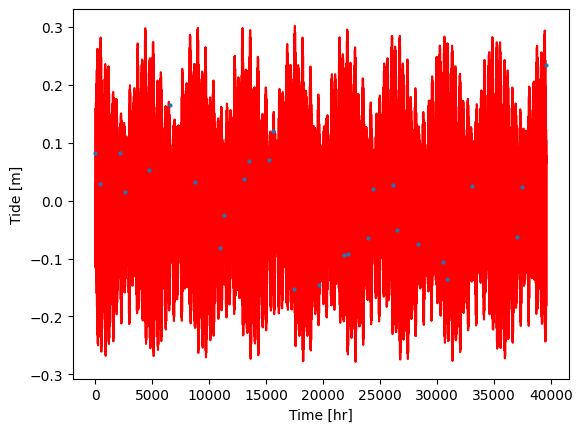

In [9]:
t = df["time"].values
data = df["h_corr"].values
periods = [constituents[c] for c in constituents]

# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)
fit_times = np.arange(0, df["time"].iloc[-1], 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

NameError: name 'LatLon' is not defined

In [ ]:
# Try with taking points from CATS
tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

tide_times = df["datetime"].values
gz05_lat = -84.2986
gz05_lon = -164.5206

"""
tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [lon],
    [lat],
    dates_timeseries,
).data.T[0]
"""

AttributeError: module 'Tides' has no attribute 'Tide'